In [1]:
# Import libraries
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from matplotlib.patches import Polygon
from shapely.geometry import Polygon as ShapelyPolygon

In [2]:
# Load Syntax data
with open('data/syntax/train/annotations/train.json') as f:
     syntax_train = pd.json_normalize(json.load(f), 'annotations')

with open('data/syntax/val/annotations/val.json') as f:     
     syntax_val = pd.json_normalize(json.load(f), 'annotations')

with open('data/syntax/test/annotations/test.json') as f:
     syntax_test = pd.json_normalize(json.load(f), 'annotations')

# Preview Syntax data
syntax_train.head()

,id,image_id,category_id,segmentation,area,bbox,iscrowd,attributes.occluded
0,1,922,8,"[[382.0, 350.75, 380.25, 349.5, 378.75, 348.5,...",442.0,"[341.0, 232.0, 41.0, 119.0]",0,False
1,2,922,6,"[[199.25, 112.19, 207.12, 116.31, 211.38, 115....",786.0,"[199.25, 106.81, 98.0, 47.07]",0,False
2,3,922,5,"[[183.62, 136.5, 188.12, 134.88, 192.88, 130.1...",323.0,"[178.12, 112.0, 24.88, 25.25]",0,False
3,4,922,7,"[[295.5, 151.75, 297.5, 148.88, 300.25, 150.25...",567.0,"[293.0, 148.88, 52.5, 85.12]",0,False
4,5,793,16,"[[266.0, 316.5, 267.25, 317.75, 271.5, 314.5, ...",540.0,"[238.88, 227.12, 34.62, 90.63]",0,False


In [3]:
# Load Stenosis data
with open('data/stenosis/train/annotations/train.json') as f:
    stenosis_train = pd.json_normalize(json.load(f), 'annotations')

with open('data/stenosis/val/annotations/val.json') as f:
    stenosis_val = pd.json_normalize(json.load(f), 'annotations')

with open('data/stenosis/test/annotations/test.json') as f:
    stenosis_test = pd.json_normalize(json.load(f), 'annotations')

# Preview Stenosis data
stenosis_train.head()

,id,image_id,category_id,segmentation,area,bbox,iscrowd,attributes.occluded
0,1,676,26,"[[278.0, 291.75, 286.75, 299.25, 289.5, 296.25...",708.0,"[278.0, 245.12, 42.75, 54.13]",0,False
1,2,960,26,"[[294.75, 315.0, 293.0, 322.0, 298.5, 322.5, 3...",457.0,"[293.0, 315.0, 68.0, 23.25]",0,False
2,3,960,26,"[[102.0, 172.25, 109.31, 179.25, 113.0, 175.75...",317.0,"[102.0, 157.38, 34.25, 21.87]",0,False
3,4,960,26,"[[87.69, 192.62, 96.69, 198.75, 95.81, 203.0, ...",388.0,"[84.38, 192.62, 12.31, 43.63]",0,False
4,5,99,26,"[[326.0, 232.62, 330.25, 231.38, 335.0, 239.75...",255.0,"[323.0, 221.25, 25.5, 26.13]",0,False


In [4]:
# Load label categories
with open('data/syntax/test/annotations/test.json') as f:
     categories= pd.json_normalize(json.load(f), 'categories')

# Show label categories
display(categories)

,id,name,supercategory
0,1,1,
1,2,2,
2,3,3,
3,4,4,
4,5,5,
5,6,6,
6,7,7,
7,8,8,
8,9,9,
9,10,9a,


In [5]:
# id, image_id, category_id, segmentation, area, and bbox are clearly valuable fields
# Review the other fields to confirm usefulness
print(syntax_train['iscrowd'].unique())
print(syntax_train['attributes.occluded'].unique())
print(stenosis_train['iscrowd'].unique())
print(stenosis_train['attributes.occluded'].unique())

[0]
[False]
[0]
[False]


In [6]:
# Drop area, bbox, iscrowd and attributed.occluded fields, which add no information
syntax_train.drop(['area','bbox','iscrowd','attributes.occluded'], axis=1, inplace=True)
syntax_val.drop(['area','bbox','iscrowd','attributes.occluded'], axis=1, inplace=True)
syntax_test.drop(['area','bbox','iscrowd','attributes.occluded'], axis=1, inplace=True)
stenosis_train.drop(['area','bbox','iscrowd','attributes.occluded'], axis=1, inplace=True)
stenosis_val.drop(['area','bbox','iscrowd','attributes.occluded'], axis=1, inplace=True)
stenosis_test.drop(['area','bbox','iscrowd','attributes.occluded'], axis=1, inplace=True)

# Check syntax_train data
stenosis_train.head()

,id,image_id,category_id,segmentation
0,1,676,26,"[[278.0, 291.75, 286.75, 299.25, 289.5, 296.25..."
1,2,960,26,"[[294.75, 315.0, 293.0, 322.0, 298.5, 322.5, 3..."
2,3,960,26,"[[102.0, 172.25, 109.31, 179.25, 113.0, 175.75..."
3,4,960,26,"[[87.69, 192.62, 96.69, 198.75, 95.81, 203.0, ..."
4,5,99,26,"[[326.0, 232.62, 330.25, 231.38, 335.0, 239.75..."


In [7]:
# Add actual Syntax categories in and drop category_id
syntax_train = syntax_train.merge(categories[['id','name']], left_on='category_id', right_on='id', how='left').drop(['category_id', 'id_x', 'id_y'], axis=1)
syntax_train = syntax_train.rename(columns={'name': 'syntax_label'})
syntax_val = syntax_val.merge(categories[['id','name']], left_on='category_id', right_on='id', how='left').drop(['category_id', 'id_x', 'id_y'], axis=1)
syntax_val = syntax_val.rename(columns={'name': 'syntax_label'})
syntax_test = syntax_test.merge(categories[['id','name']], left_on='category_id', right_on='id', how='left').drop(['category_id', 'id_x', 'id_y'], axis=1)
syntax_test = syntax_test.rename(columns={'name': 'syntax_label'})
stenosis_train = stenosis_train.merge(categories[['id','name']], left_on='category_id', right_on='id', how='left').drop(['category_id', 'id_x', 'id_y'], axis=1)
stenosis_train = stenosis_train.rename(columns={'name': 'syntax_label'})
stenosis_val = stenosis_val.merge(categories[['id','name']], left_on='category_id', right_on='id', how='left').drop(['category_id', 'id_x', 'id_y'], axis=1)
stenosis_val = stenosis_val.rename(columns={'name': 'syntax_label'})
stenosis_test = stenosis_test.merge(categories[['id','name']], left_on='category_id', right_on='id', how='left').drop(['category_id', 'id_x', 'id_y'], axis=1)
stenosis_test = stenosis_test.rename(columns={'name': 'syntax_label'})

stenosis_train.head()

,image_id,segmentation,syntax_label
0,676,"[[278.0, 291.75, 286.75, 299.25, 289.5, 296.25...",stenosis
1,960,"[[294.75, 315.0, 293.0, 322.0, 298.5, 322.5, 3...",stenosis
2,960,"[[102.0, 172.25, 109.31, 179.25, 113.0, 175.75...",stenosis
3,960,"[[87.69, 192.62, 96.69, 198.75, 95.81, 203.0, ...",stenosis
4,99,"[[326.0, 232.62, 330.25, 231.38, 335.0, 239.75...",stenosis


In [8]:
# Create a helper function to retrieve images

def get_image_path(dataset_name, image_id):
    """
    Construct an image path based on a dataset and a sample id.

    Args:
        dataset_name (string): name of the dataset
        id (integer): id of the sample

    Returns:
        image_path (string): the path of the image
    """
    image_folders = {
        'syntax_train' : 'data/syntax/train/images/',
        'syntax_val' : 'data/syntax/val/images/',
        'syntax_test' : 'data/syntax/test/images/',
        'stenosis_train' : 'data/stenosis/train/images/',
        'stenosis_val' : 'data/stenosis/val/images/',
        'stenosis_test' : 'data/stenosis/test/images'
    }

    image_path = image_folders[dataset_name] + str(image_id) + '.png'

    return image_path

In [23]:
# Create helper function to display five random images with annotations
# from a given dataset

def show_images(dataset, dataset_name, ids, ncols=5):
    """
    Display images with annotations for a given dataset.

    Args:
        dataset (Pandas DataFrame): the dataset
        dataset_name (string): the name of the dataset variable
        ids (numpy array): image ids to be shown
    """

    dataset = dataset.groupby('image_id').agg(list).reset_index()

    nrows = (len(ids)-1) // ncols + 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, nrows*4))
    axes = axes.flatten()
    for ax, id, in zip(axes.flat, ids):
        image_path = get_image_path(dataset_name, id)
        image = Image.open(image_path)
        ax.imshow(image)
        segmentation_list = dataset.loc[dataset['image_id'] == id, 'segmentation'].iloc[0]
        label_list = dataset.loc[dataset['image_id'] == id, 'syntax_label'].iloc[0]
        for segmentation, label in zip(segmentation_list, label_list):
            poly_points = np.array(segmentation).reshape(-1,2)
            center = ShapelyPolygon(poly_points)
            centroid_x, centroid_y = center.centroid.x, center.centroid.y
            label_x, label_y = centroid_x - 60, centroid_y
            if label == 'stenosis':
                color='red'
            else:
                color='yellow'
                ax.plot([centroid_x, label_x+5], [centroid_y, label_y], color='yellow', linewidth=0.4) 
                ax.text(label_x, label_y, label, color='yellow', fontsize=8,
                    verticalalignment='center', horizontalalignment='right')
            poly = Polygon(poly_points,
                           edgecolor=color,
                           facecolor='none',
                           linewidth=0.4)            
            ax.add_patch(poly)    
        ax.set_title(f"image_id: {id}")
        ax.axis('off')

    fig.suptitle(dataset_name)
    plt.tight_layout()
    fig.subplots_adjust(top=1.25)
    plt.show()

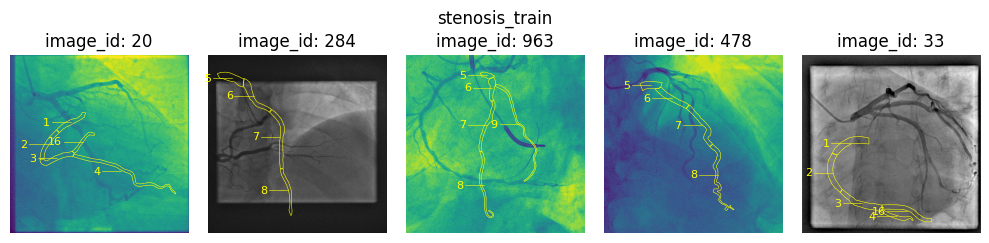

In [24]:
# Show five random segmentations for Syntax
ids = syntax_train['image_id'].sample(n=5, random_state=0)
show_images(syntax_train, 'stenosis_train', ids)

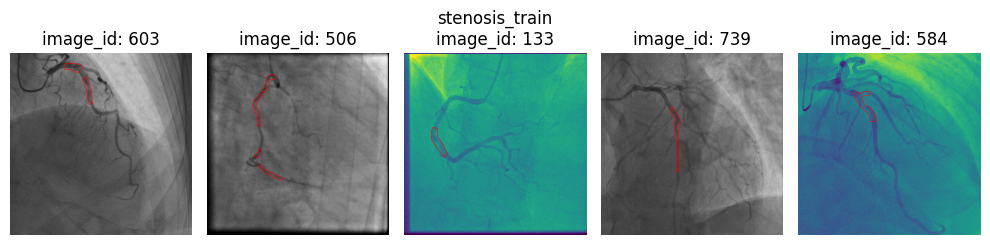

In [25]:
# Show five random segmenations for Stenosis
ids = stenosis_train['image_id'].sample(n=5, random_state=0)
show_images(stenosis_train, 'stenosis_train', ids)